In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optimizer
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.FloatTensor

In [2]:
sentences = ["jack like dog", "jack like cat", "jack like animal",
  "dog cat animal", "banana apple cat dog like", "dog fish milk like",
  "dog cat animal like", "jack like apple", "apple like", "jack like banana",
  "apple banana jack movie book music like", "cat dog hate", "cat dog like"]
sentences_list = ' '.join(sentences).split()
vocab = list(set(sentences_list))
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}
vocab_size = len(vocab)

In [3]:

# model parameters
C = 2 # window size
batch_size = 8
m = 2 # word embedding dim

In [4]:
skip_grams = []
for idx in range(C,len(sentences_list)-C):
    center = word2idx[sentences_list[idx]]
    context_idx = list(range(idx-C,idx)) + list(range(idx+1,idx+1+C))
    context = [word2idx[sentences_list[word_idx]] for word_idx in context_idx]
    for w in context:
        skip_grams.append([center,w])


In [5]:
def make_data(skip_grams):
    input_data = []
    output_data = []
    for a,b in skip_grams:
        input_data.append(np.eye(vocab_size)[a])
        output_data.append(b)
    return input_data,output_data


In [6]:
input_data,output_data = make_data(skip_grams)
input_data,output_data = torch.Tensor(input_data),torch.LongTensor(output_data)
dataset = Data.TensorDataset(input_data,output_data)
loader = Data.DataLoader(dataset,batch_size,True)

In [7]:
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec,self).__init__()
        self.W = nn.Parameter(torch.randn(vocab_size,m).type(dtype))
        self.V = nn.Parameter(torch.randn(m,vocab_size).type(dtype))
    def forward(self,X):
        hidden = torch.mm(X,self.W)
        output = torch.mm(hidden,self.V)
        return output
        

In [8]:
model = Word2Vec().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optim = optimizer.Adam(model.parameters(), lr=1e-3)

In [9]:
for epoch  in range (2000):
    for i,(batch_x,batch_y) in enumerate(loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        pred = model(batch_x)
        loss = loss_fn(pred,batch_y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    if (epoch + 1) % 100 == 0:
        print(epoch + 1, i, loss.item(),end='\r')
    

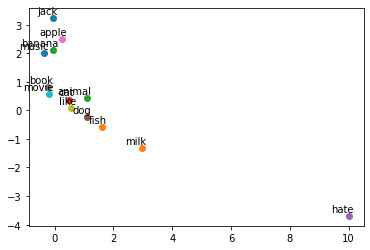

In [10]:
import matplotlib.pyplot as plt
for i, label in enumerate(vocab):
    W, WT = model.parameters()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()